## PART 1 - GAN

### Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [1]:
## Loading the Fashion MNIST dataset
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
                              train=True,
                              download=True,
                              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

This code snippet loads the Fashion MNIST dataset using PyTorch, applying transformations to the images before they're ready for training in a deep learning model.

#### Libraries Imported : 
The code imports PyTorch (torch) and torchvision, along with utilities for image transformations (ToTensor, Normalize, Compose) and the FashionMNIST dataset.

#### Transformation Pipeline:
Images are first converted to PyTorch tensors using ToTensor(), which scales pixel values to the range [0, 1]. Then, Normalize(mean=(0.5,), std=(0.5,)) scales the pixel values further to the range [-1, 1] to help the model train more efficiently.

#### Dataset Loading:
The Fashion MNIST dataset (60,000 training images) is downloaded and stored in the 'data' directory if not already present. The dataset contains 28x28 grayscale images of 10 fashion item categories.

In [2]:
# Printing particular image and label
img, label = fashion_mnist[0]
print('Label: ', label)
print('Image shape:', img.shape)
# Displaying a portion of the image
print(img[:, 10:15, 10:15])  
print('Minimum pixel value:', torch.min(img))
print('Maximum pixel value:', torch.max(img))

Label:  9
Image shape: torch.Size([1, 28, 28])
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])
Minimum pixel value: tensor(-1.)
Maximum pixel value: tensor(1.)


The code begins by extracting a single image and its corresponding label from the fashion_mnist dataset using fashion_mnist[0].

It prints the label (label) and the shape of the image (img.shape).

A portion of the image (pixels from coordinates [10:15, 10:15]) is printed to display a small part of the image array.

It also prints the minimum and maximum pixel values of the image to understand the pixel intensity range.

Label: 9


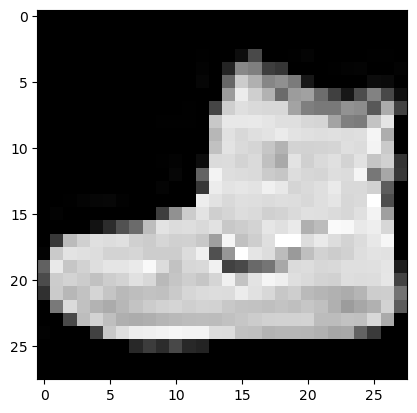

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)
# Printing an image
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

A helper function denorm(x) is defined to denormalize the image data.

It rescales the pixel values from the range [-1, 1] to [0, 1] to prepare the image for visualization.

The function also clamps the values to ensure they remain within [0, 1].

The denormalized image (img_norm) is displayed using matplotlib with a grayscale (cmap='gray') color map.

The label of the image is printed along with the visualization.

### Data Loader

In [4]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([5, 1, 2, 4, 6, 9, 9, 1, 3, 0, 6, 3, 3, 0, 1, 8, 1, 5, 4, 3, 8, 9, 6, 0,
        4, 2, 1, 0, 4, 1, 0, 4, 8, 9, 0, 2, 5, 6, 6, 3, 7, 2, 8, 3, 6, 5, 8, 2,
        2, 9, 5, 9, 8, 6, 2, 4, 8, 0, 4, 2, 7, 9, 6, 7, 4, 7, 8, 1, 9, 9, 4, 6,
        2, 5, 1, 4, 8, 4, 7, 9, 2, 6, 8, 3, 8, 7, 1, 7, 5, 6, 4, 6, 1, 4, 2, 6,
        5, 3, 9, 7])


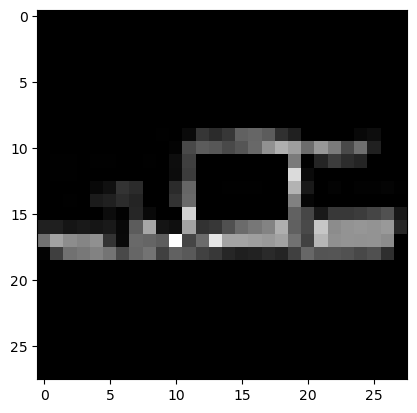

In [5]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

A DataLoader is created for the fashion_mnist dataset with a batch size of 100, and shuffling is enabled to randomize the order of samples.

The code loops through the first batch of images (img_batch) and labels (label_batch) from the DataLoader and prints "first batch" when the first batch is processed.


In [6]:
# Configuring a device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Step2. Train the GAN Model to produce Images in this New Domain.

### Discriminator

In [7]:
image_size = 784
hidden_size = 256
# Discriminator layers
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.to(device);

A neural network D (Discriminator) is defined using torch.nn.Sequential.

The input size (image_size) is set to 784 (28x28 pixels, flattened). The hidden_size is set to 256.

The architecture consists of:
First layer: Fully connected layer (nn.Linear) from 784 to 256.

Activation: LeakyReLU with a negative slope of 0.2 for better gradient flow.

Second layer: Another fully connected layer from 256 to 256.

Activation: LeakyReLU(0.2).

Output layer: Fully connected layer from 256 to 1, followed by a Sigmoid activation to output probabilities for real or fake classification.

The model is transferred to the specified device (either GPU or CPU).

### Generator

In [8]:
latent_size = 64
# Generator layers
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

A neural network G (Generator) is also defined using torch.nn.Sequential.

The input to the generator is a latent vector of size 64 (latent_size = 64), typically random noise.

The architecture consists of:
First layer: Fully connected layer from 64 (latent space) to 256.

Activation: ReLU activation function for non-linearity.
Second layer: Another fully connected layer from 256 to 256.
Activation: ReLU again.

Output layer: Fully connected layer from 256 to 784, followed by a Tanh activation to normalize the output between -1 and 1, matching the image normalization.

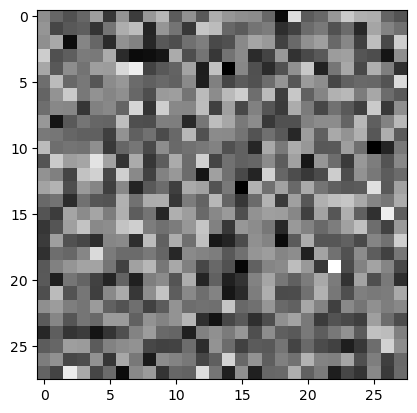

In [9]:
plt.imshow(gen_imgs[00], cmap='gray');

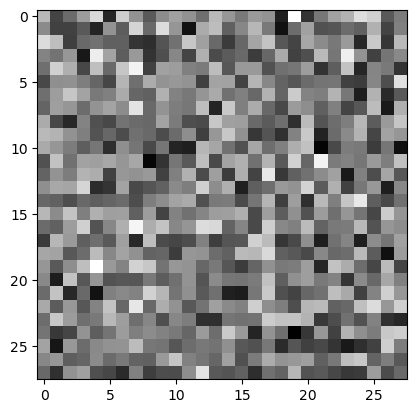

In [10]:
plt.imshow(gen_imgs[1], cmap='gray');

In [11]:
G.to(device);

### Discriminator Training

In [12]:
# Training the discriminator
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [13]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Labels for the images
def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

## Loss for real and fake images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

## Combining the losses
    d_loss = d_loss_real + d_loss_fake

## Computation of Gradients
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_score, fake_score

This code defines the training process for the discriminator in a Generative Adversarial Network (GAN). Here's a breakdown of each part:

1. Loss Function (criterion):
The binary cross-entropy loss (nn.BCELoss()) is used to compute the loss for both real and fake images. This loss is used because the discriminator is a binary classifier that predicts whether an image is real (1) or fake (0).

2. Optimizer for Discriminator:
The Adam optimizer is defined to update the discriminator's parameters, with a learning rate (lr) of 0.0002.

3. Gradient Reset Function:
The function reset_grad() is used to zero out the gradients of both the discriminator and generator optimizers before backpropagation. This ensures that gradients from previous batches are not accumulated.

4. Label Definitions:
Inside the train_discriminator function:
real_labels: A tensor filled with 1s, representing the ground truth for real images (i.e., the label for real images).
fake_labels: A tensor filled with 0s, representing the ground truth for fake images (i.e., the label for fake images generated by the generator).

5. Discriminator Loss for Real Images:
The discriminator (D) is given a batch of real images (images).
It computes the predicted probability (outputs) that these images are real.
The loss for real images (d_loss_real) is computed by comparing the predictions (outputs) with the ground truth labels (real_labels) using the BCELoss criterion.
The real_score stores the discriminator's predicted probabilities for the real images.

6. Discriminator Loss for Fake Images:
A batch of random latent vectors (z) is generated and passed through the generator (G) to produce fake images (fake_images).
The discriminator (D) evaluates these fake images, and the predictions are stored in outputs.
The loss for the fake images (d_loss_fake) is computed by comparing the discriminator's predictions with the ground truth fake_labels.
The fake_score stores the discriminator's predicted probabilities for the fake images.

7. Combining the Losses:
The total discriminator loss (d_loss) is the sum of the loss on real images (d_loss_real) and the loss on fake images (d_loss_fake).

8. Backpropagation and Optimization:
Gradients are reset using reset_grad() to avoid accumulation from previous batches.
The total discriminator loss (d_loss) is backpropagated using d_loss.backward(), computing the gradients for the discriminator's parameters.
The d_optimizer.step() updates the discriminator's weights using the computed gradients.

9. Return Values:
The function returns:
d_loss: The total loss for the discriminator.
real_score: The discriminator’s prediction for real images.
fake_score: The discriminator’s prediction for fake images.


### Generator Training

In [14]:
## Optimizer
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [15]:
## Computing loss
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

This code defines the training process for the generator in a Generative Adversarial Network (GAN). Here's a breakdown of each component:

1. Optimizer for Generator:
The Adam optimizer (g_optimizer) is used to update the generator's parameters (G.parameters()), with a learning rate (lr) of 0.0002. This optimizer helps in minimizing the loss for the generator during training.

2. Training the Generator (train_generator Function):
The goal of the generator is to produce fake images that can fool the discriminator into classifying them as real. The training process is as follows:

### Steps in train_generator Function:
1. Generate Latent Vectors (z):
A batch of random noise vectors (z) is sampled from a normal distribution using torch.randn(batch_size, latent_size). This latent vector serves as the input to the generator.
The latent space size is latent_size (64 in this case), and batch_size refers to the number of generated images.

2. Generate Fake Images:
The generator (G) takes the latent vectors z as input and produces fake images (fake_images). The generator's goal is to generate images that are similar enough to real images such that the discriminator struggles to differentiate them from real ones.

3. Label for Fake Images:
The labels (labels) are set to 1s for the fake images, as the generator wants the discriminator to classify the fake images as real. The generator aims to fool the discriminator, so these labels indicate that the generator is trying to create convincing images.

4. Generator Loss:
The generator loss (g_loss) is computed by passing the fake images through the discriminator (D(fake_images)). The output of the discriminator (which is a probability between 0 and 1) is compared with the target label of 1 (real) using the binary cross-entropy loss (criterion).
The objective here is for the generator to minimize the loss, which means producing images that can fool the discriminator.

5. Reset Gradients:
The gradients are reset using reset_grad() to ensure that previous gradient values are not accumulated during backpropagation.

6. Backpropagation and Optimizer Step:
The generator's loss (g_loss) is backpropagated using g_loss.backward(), which computes the gradients for the generator’s parameters.
The g_optimizer.step() updates the generator's weights using the computed gradients, allowing the generator to improve and produce more realistic images over time.

7. Return Values:
The function returns:
g_loss: The loss for the generator, indicating how well it is performing.
fake_images: The generated images from the current batch of latent vectors.

### Training the Model

In [16]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

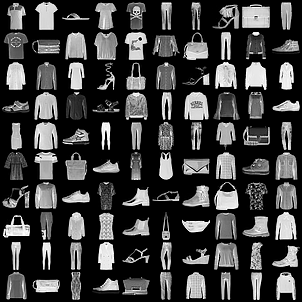

In [17]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Directory Setup: The code checks if a directory named 'samples' exists, and creates it if not.

Saving Real Images: It loads a batch of real images from data_loader, reshapes them, and saves them as a grid (real_images.png) using torchvision.utils.save_image.

Display Image: The saved image is then displayed using IPython.display.Image

Saving fake_images-0000.png


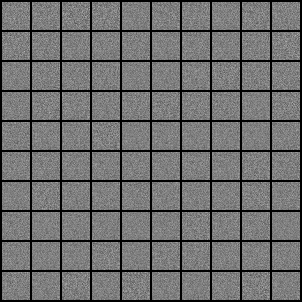

In [18]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

This code is used to generate and save fake images before training starts, which can later be compared with post-training images.

Generate Sample Vectors: A batch of random latent vectors (sample_vectors) is generated using torch.randn, which will serve as input to the generator.

### save_fake_images Function:
1. This function generates fake images using the generator (G) from the latent vectors.
2. It reshapes the generated images to the shape (batch_size, 1, 28, 28) for proper visualization.
3. The generated images are saved as PNG files using the format fake_images-XXXX.png where XXXX is the index provided to the function.
4. torchvision.utils.save_image is used to save the denormalized images.

### Save Initial Fake Images:
1. Before training, the function is called with an index of 0 to save a set of generated fake images as fake_images-0000.png.
2. Display Image: The saved fake image (fake_images-0000.png) is displayed using IPython.display.Image.


In [20]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0884, g_loss: 3.8457, D(x): 0.98, D(G(z)): 0.06
Epoch [0/300], Step [400/600], d_loss: 0.0725, g_loss: 5.9540, D(x): 0.98, D(G(z)): 0.04
Epoch [0/300], Step [600/600], d_loss: 0.1103, g_loss: 4.0235, D(x): 0.97, D(G(z)): 0.08
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0242, g_loss: 4.8672, D(x): 1.00, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0704, g_loss: 3.5984, D(x): 0.99, D(G(z)): 0.05
Epoch [1/300], Step [600/600], d_loss: 0.0222, g_loss: 6.3411, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0288, g_loss: 6.3051, D(x): 0.98, D(G(z)): 0.00
Epoch [2/300], Step [400/600], d_loss: 0.0684, g_loss: 7.9120, D(x): 0.98, D(G(z)): 0.02
Epoch [2/300], Step [600/600], d_loss: 0.0206, g_loss: 5.4416, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0978, g_loss: 5.4177, D(x): 0.99, D(G(z)): 0.07
Epoch [3/300], Step [400/6

This code is for training a GAN model, logging progress, and saving generated images at the end of each epoch for visualization.

Training Loop: The code sets up a training loop for the GAN model over 300 epochs. It iterates over the data_loader to fetch real images and train both the discriminator and generator in each iteration.

### Batch Processing:
1. Each batch of real images is reshaped and sent to the device (GPU/CPU).
2. The discriminator is trained using real and fake images (generated by the generator), and its loss and prediction scores are computed.
3. The generator is trained to minimize the loss based on the discriminator's feedback and outputs fake images.

### Logging Metrics:
Every 200 steps, the discriminator and generator losses, along with real and fake scores, are logged. The losses (d_loss, g_loss), real scores (D(x)), and fake scores (D(G(z))) are appended to lists for later analysis.

### Image Sampling: 
After every epoch, the current generator model is used to sample and save a batch of fake images using the save_fake_images(epoch+1) function.

### Performance Measurement: 
The code uses %%time to track the total time taken to execute the training process.

#### Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

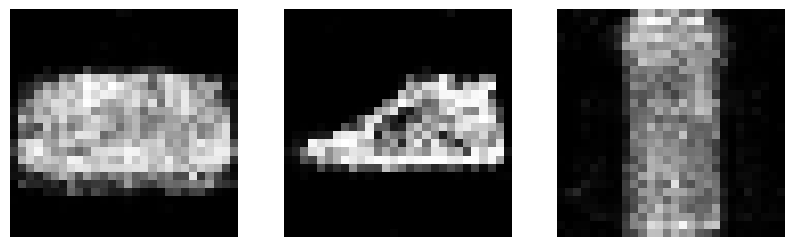

In [21]:
def save_fake_3_images(epoch, fake_images, num_images=3):
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)  # Reshape to original image shape
    fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]

    # Plot and save the first 3 generated images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 3))
    for i in range(num_images):
        axes[i].imshow(fake_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()
save_fake_3_images(epoch+1, fake_images)

The save_fake_images function is designed to save and display at least 3 samples generated by the GAN model. Here's a brief explanation of the steps:

1. Reshape the Fake Images:
The fake images generated by the GAN are initially flattened, so they need to be reshaped back into their original image dimensions of 28x28 pixels (with 1 channel for grayscale).
The reshaping is done with the line fake_images.reshape(fake_images.size(0), 1, 28, 28).

2. Rescale the Image Values:
GANs typically generate images in the range of [-1, 1] because of the Tanh activation used in the generator. For visualization, the images are rescaled to the [0, 1] range by using the formula (fake_images + 1) / 2.

3. Plot and Display Images:
A subplot with num_images=3 is created, and the first 3 fake images are displayed using plt.imshow(). The detach() method ensures that the gradients are not tracked, and .cpu() moves the tensors back to the CPU from the GPU for visualization.
The generated images are displayed as grayscale images.

4. Call the Function:
The function save_fake_images(epoch+1, fake_images) is called after each epoch to save and display the images generated during that epoch.

### Difficulties Faced:

1. Reshaping Issues:
Challenge: Generated images may initially be in a flattened format (batch_size, 784), which could cause errors if not reshaped properly for display.
Solution: The reshaping step ensures that the fake images are correctly reshaped back into (batch_size, 1, 28, 28) before plotting.

2. Image Rescaling:
Challenge: The GAN outputs pixel values in the range [-1, 1], which can cause the displayed images to look too dark or incorrect if not rescaled.
Solution: The (fake_images + 1) / 2 rescaling adjusts the pixel values to the appropriate range [0, 1] for visualization.

3. Batch Size:
Challenge: If the batch size is smaller than 3 or if the number of fake images is less than 3, this could cause an error.
Solution: Ensure that the number of generated images is at least equal to num_images=3 to avoid index errors.

4. CUDA Compatibility:
Challenge: If the tensors are on a GPU, directly plotting them using matplotlib will cause errors since matplotlib expects CPU-based tensors.
Solution: Use .cpu() to move the tensors to the CPU before calling .numpy() to convert them into a NumPy array for plotting.

After addressing these challenges, the function successfully displays the generated images.

#### Step4. Save the model weights in the folder to be used later.

In [22]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G2.ckpt')
torch.save(D.state_dict(), 'D2.ckpt')

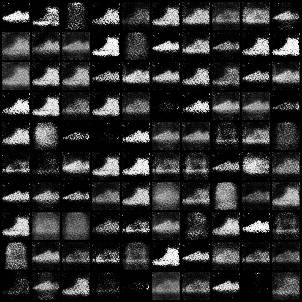

In [23]:
Image('./samples/fake_images-0015.png')

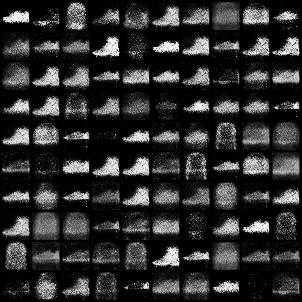

In [24]:
Image('./samples/fake_images-0020.png')

#### Step5. Load the model using the saved weights and 

#### Step 6: Re-train the GAN model to see if you can improve.



Training the Model again with different batch

In [25]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784


# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
#loaded with saved weights
G.load_state_dict(torch.load('G2.ckpt'))  
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
#loaded with saved weights
D.load_state_dict(torch.load('D2.ckpt'))
D.eval()


/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_84842/1327986864.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('G2.ckpt'))
/va

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

Generator (G): A neural network is defined with an input latent size of 64, two hidden layers of size 256, and an output layer that reshapes the output into a 784-dimensional vector (28x28 image). The Tanh activation is used to normalize the output.

Discriminator (D): A binary classifier with input size 784 (flattened image), two hidden layers of 256 units, and a Sigmoid output layer for real/fake classification.

Loading Saved Weights: The generator and discriminator models are loaded with previously saved weights (G2.ckpt and D2.ckpt), and the models are set to evaluation mode (eval()).

In [26]:
# Training the discriminator
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [27]:
%%time

num_epochs = 150
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Move the model to the same device as provided data
D.to(device)
G.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/150], Step [200/600], d_loss: 1.2317, g_loss: 1.0810, D(x): 0.62, D(G(z)): 0.41
Epoch [0/150], Step [400/600], d_loss: 1.4394, g_loss: 1.0626, D(x): 0.55, D(G(z)): 0.40
Epoch [0/150], Step [600/600], d_loss: 1.3566, g_loss: 1.0113, D(x): 0.60, D(G(z)): 0.44
Saving fake_images-0001.png
Epoch [1/150], Step [200/600], d_loss: 1.2657, g_loss: 1.0589, D(x): 0.63, D(G(z)): 0.42
Epoch [1/150], Step [400/600], d_loss: 1.5431, g_loss: 1.0069, D(x): 0.55, D(G(z)): 0.43
Epoch [1/150], Step [600/600], d_loss: 0.9444, g_loss: 1.3756, D(x): 0.70, D(G(z)): 0.34
Saving fake_images-0002.png
Epoch [2/150], Step [200/600], d_loss: 0.9054, g_loss: 1.4114, D(x): 0.66, D(G(z)): 0.27
Epoch [2/150], Step [400/600], d_loss: 0.8285, g_loss: 1.5746, D(x): 0.68, D(G(z)): 0.25
Epoch [2/150], Step [600/600], d_loss: 1.3313, g_loss: 0.9342, D(x): 0.61, D(G(z)): 0.44
Saving fake_images-0003.png
Epoch [3/150], Step [200/600], d_loss: 1.3402, g_loss: 1.0874, D(x): 0.63, D(G(z)): 0.46
Epoch [3/150], Step [400/6

1. Optimizers: Adam optimizers are defined for both the discriminator (D) and generator (G) with a learning rate of 0.0002.
2. Training Loop: The code trains the GAN for 150 epochs:
3. Discriminator: Trained with real and fake images to compute loss and update weights.
4. Generator: Trained to generate fake images that can fool the discriminator.
5. Loss Tracking: Discriminator and generator losses, along with real and fake scores, are logged every 200 steps.
6. Image Sampling: After each epoch, a batch of fake images is saved using the save_fake_images function.
7. Timing: %%time is used to measure the total training time.
This code trains the GAN, logs losses, and saves generated images at the end of each epoch.

#### Step 7: Save the model weights without using checkpoints.



In [28]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G3.pth')
torch.save(D.state_dict(), 'D3.pth')

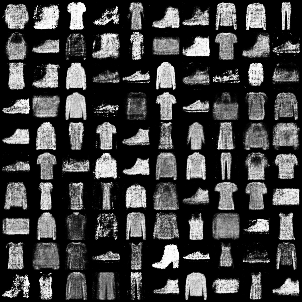

In [29]:
Image('./samples/fake_images-0015.png')

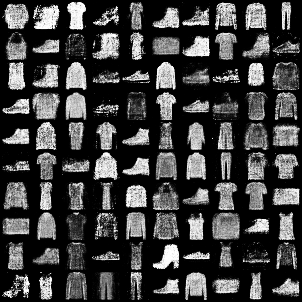

In [30]:
Image('./samples/fake_images-0020.png')

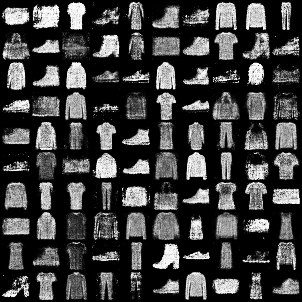

In [31]:
Image('./samples/fake_images-0250.png')

In [32]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


/Users/shamalachandrappa/Desktop/Git Hub Push Everyday/DL/Assignment-5/gans_training.avi

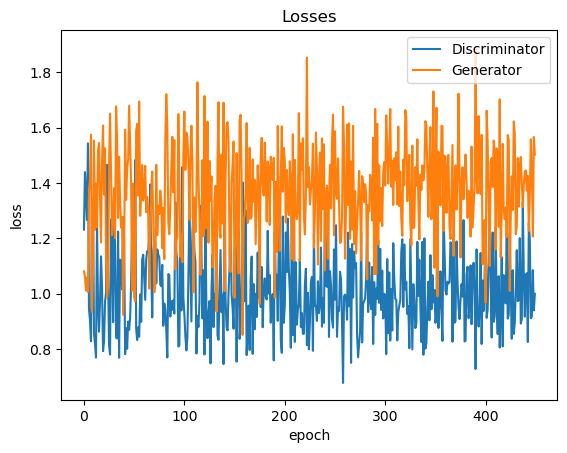

In [33]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

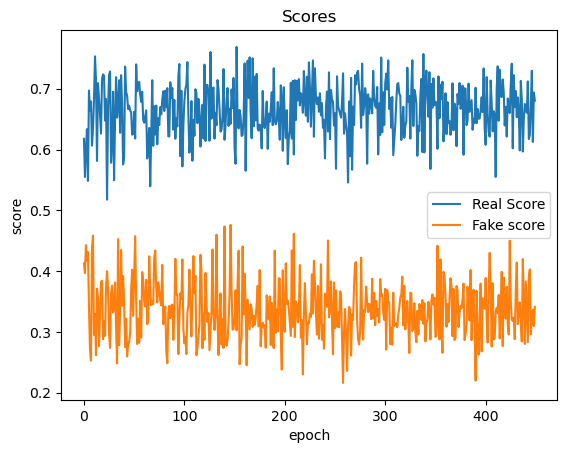

In [34]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

#### Step 8: Load the model weights without using checkpoints.


In [35]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784


# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.load_state_dict(torch.load('G3.pth'))  #loading the saved weights without saving the weights at checkpoint
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.load_state_dict(torch.load('D3.pth'))
D.eval()

/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_84842/298516091.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('G3.pth'))  #loa

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

# Part 2 - Least Square GAN

#### Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [36]:
## Loading the Fashion MNIST dataset
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
                              train=True,
                              download=True,
                              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [37]:
# Printing particular image and label
img, label = fashion_mnist[0]
print('Label: ', label)
print('Image shape:', img.shape)
print(img[:, 10:15, 10:15])  # Displaying a portion of the image
print('Minimum pixel value:', torch.min(img))
print('Maximum pixel value:', torch.max(img))

Label:  9
Image shape: torch.Size([1, 28, 28])
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])
Minimum pixel value: tensor(-1.)
Maximum pixel value: tensor(1.)


In [38]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


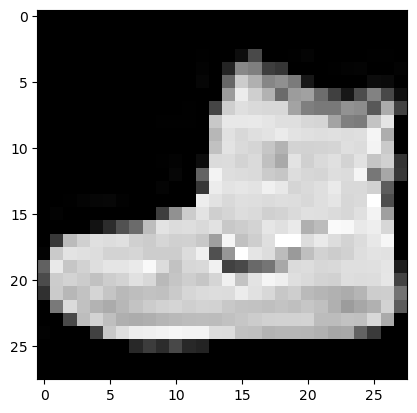

In [39]:
# Printing an image
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

### Data loader

In [40]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([6, 1, 8, 2, 2, 5, 1, 6, 5, 7, 4, 2, 0, 0, 5, 6, 0, 4, 6, 4, 7, 5, 1, 0,
        5, 5, 0, 7, 6, 7, 3, 7, 2, 7, 0, 6, 8, 1, 9, 6, 3, 3, 8, 4, 2, 4, 7, 2,
        7, 6, 1, 0, 9, 8, 5, 3, 9, 9, 9, 4, 4, 5, 2, 1, 5, 8, 0, 3, 6, 7, 8, 7,
        3, 3, 8, 7, 2, 3, 2, 1, 9, 6, 5, 1, 4, 5, 7, 4, 9, 8, 2, 4, 1, 8, 6, 8,
        6, 2, 6, 3])


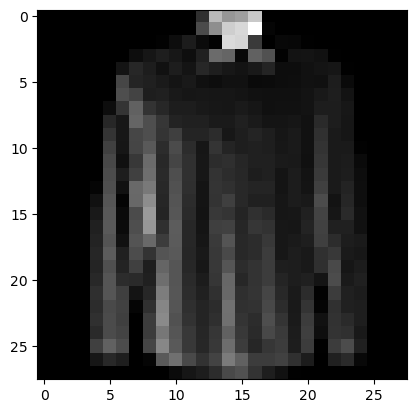

In [41]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [42]:
# Configuring a device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

### Discriminator

In [43]:
image_size = 784
hidden_size = 256
# Discriminator layers
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.to(device);

### Generator

In [44]:
latent_size = 64
# Generator layers
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

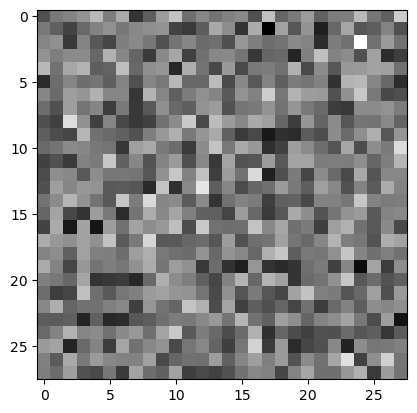

In [45]:
plt.imshow(gen_imgs[00], cmap='gray');

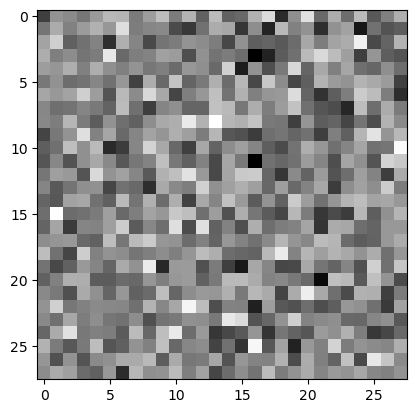

In [46]:
plt.imshow(gen_imgs[1], cmap='gray');

In [47]:
G.to(device);

#### Step2. Train the GAN model to produce images in this new domain.

### Discriminator Training

In [48]:
# Training the discriminator
# For LSGan I am using MSE loss
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [49]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Labels for the images
def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

## Loss for real and fake images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

## Combining the losses
    d_loss = d_loss_real + d_loss_fake

## Computation of Gradients
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_score, fake_score

### Generator Training

In [50]:
## Optimizer
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [51]:
## Computing loss
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

### Training the Model

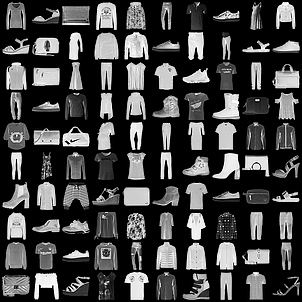

In [52]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


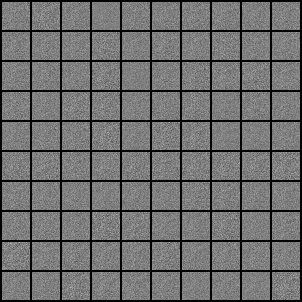

In [53]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [54]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.0730, g_loss: 0.6265, D(x): 0.96, D(G(z)): 0.26
Epoch [0/100], Step [400/600], d_loss: 0.2294, g_loss: 0.9603, D(x): 1.00, D(G(z)): 0.47
Epoch [0/100], Step [600/600], d_loss: 0.0054, g_loss: 0.9504, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.9997, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [1/100], Step [400/600], d_loss: 0.2267, g_loss: 0.9807, D(x): 0.71, D(G(z)): 0.00
Epoch [1/100], Step [600/600], d_loss: 0.2609, g_loss: 0.7584, D(x): 0.63, D(G(z)): 0.14
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.1880, g_loss: 0.8834, D(x): 0.82, D(G(z)): 0.34
Epoch [2/100], Step [400/600], d_loss: 0.1510, g_loss: 0.7475, D(x): 0.76, D(G(z)): 0.17
Epoch [2/100], Step [600/600], d_loss: 0.1909, g_loss: 0.8385, D(x): 0.84, D(G(z)): 0.31
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.1444, g_loss: 0.8864, D(x): 0.87, D(G(z)): 0.28
Epoch [3/100], Step [400/6

#### Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.



In [55]:
def save_fake_3_images(epoch, fake_images, num_images=3):
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)  # Reshape to original image shape
    fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]

    # Plot and save the first 3 generated images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 3))
    for i in range(num_images):
        axes[i].imshow(fake_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()


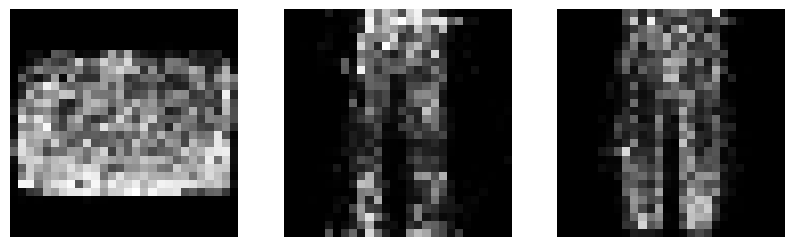

In [56]:
 # Sample and save images
save_fake_3_images(epoch+1, fake_images)

#### Step4. Save the model weights in the folder to be used later.

In [57]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G2.ckpt')
torch.save(D.state_dict(), 'D2.ckpt')

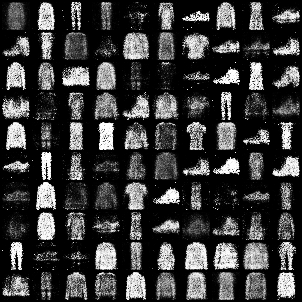

In [58]:
Image('./samples/fake_images-0015.png')

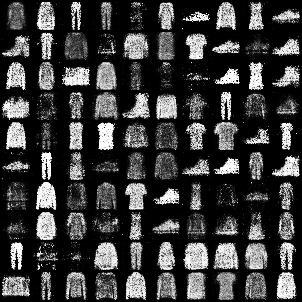

In [59]:
Image('./samples/fake_images-0020.png')

#### Step5. Load the model using the saved weights and 

#### Step 6: Re-train the GAN model to see if you can improve.

Training the Model again with different batch

In [60]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784


# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.load_state_dict(torch.load('G2.ckpt'))  #loaded with saved weights
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.load_state_dict(torch.load('D2.ckpt'))    #loaded with saved weights
D.eval()

/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_84842/344899889.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('G2.ckpt'))  #lo

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [61]:
# Training the discriminator
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [62]:
%%time

num_epochs = 150
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Move the model to the same device as provided data
D.to(device)
G.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/150], Step [200/600], d_loss: 0.3542, g_loss: 0.7109, D(x): 0.65, D(G(z)): 0.21
Epoch [0/150], Step [400/600], d_loss: 0.2696, g_loss: 0.7316, D(x): 0.84, D(G(z)): 0.26
Epoch [0/150], Step [600/600], d_loss: 0.5345, g_loss: 0.5555, D(x): 0.65, D(G(z)): 0.41
Saving fake_images-0001.png
Epoch [1/150], Step [200/600], d_loss: 0.4602, g_loss: 0.7230, D(x): 0.67, D(G(z)): 0.29
Epoch [1/150], Step [400/600], d_loss: 0.3920, g_loss: 0.8152, D(x): 0.86, D(G(z)): 0.36
Epoch [1/150], Step [600/600], d_loss: 0.4176, g_loss: 0.5184, D(x): 0.64, D(G(z)): 0.31
Saving fake_images-0002.png
Epoch [2/150], Step [200/600], d_loss: 0.4935, g_loss: 0.6586, D(x): 0.55, D(G(z)): 0.22
Epoch [2/150], Step [400/600], d_loss: 0.5221, g_loss: 0.6404, D(x): 0.69, D(G(z)): 0.40
Epoch [2/150], Step [600/600], d_loss: 0.5253, g_loss: 0.6355, D(x): 0.59, D(G(z)): 0.29
Saving fake_images-0003.png
Epoch [3/150], Step [200/600], d_loss: 0.3513, g_loss: 0.6607, D(x): 0.80, D(G(z)): 0.32
Epoch [3/150], Step [400/6

In [63]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G3.ckpt')
torch.save(D.state_dict(), 'D3.ckpt')

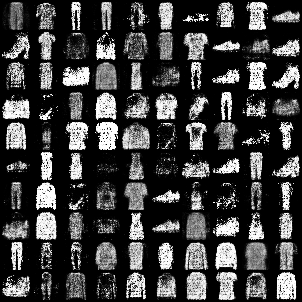

In [64]:
Image('./samples/fake_images-0015.png')

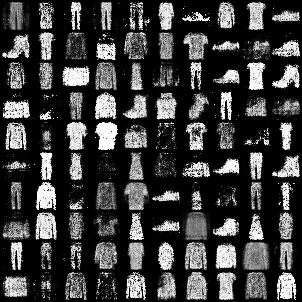

In [65]:
Image('./samples/fake_images-0020.png')

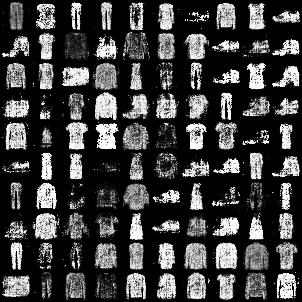

In [66]:
Image('./samples/fake_images-0001.png')

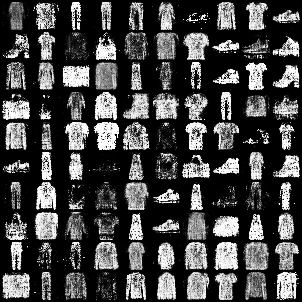

In [67]:
Image('./samples/fake_images-0002.png')

In [68]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784


# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.load_state_dict(torch.load('G3.ckpt'))  #loaded with saved weights
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.load_state_dict(torch.load('D3.ckpt'))    #loaded with saved weights
D.eval()

# Training the discriminator
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_84842/3295162032.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('G3.ckpt'))  #l

In [69]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Move the model to the same device as the provided data
D.to(device)
G.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.3530, g_loss: 0.5024, D(x): 0.68, D(G(z)): 0.39
Epoch [0/100], Step [400/600], d_loss: 0.4514, g_loss: 0.5315, D(x): 0.57, D(G(z)): 0.36
Epoch [0/100], Step [600/600], d_loss: 0.4429, g_loss: 0.4503, D(x): 0.62, D(G(z)): 0.43
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.4328, g_loss: 0.5528, D(x): 0.64, D(G(z)): 0.41
Epoch [1/100], Step [400/600], d_loss: 0.4482, g_loss: 0.3506, D(x): 0.66, D(G(z)): 0.46
Epoch [1/100], Step [600/600], d_loss: 0.4066, g_loss: 0.4672, D(x): 0.59, D(G(z)): 0.33
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.4141, g_loss: 0.5122, D(x): 0.61, D(G(z)): 0.37
Epoch [2/100], Step [400/600], d_loss: 0.4227, g_loss: 0.4647, D(x): 0.57, D(G(z)): 0.37
Epoch [2/100], Step [600/600], d_loss: 0.3920, g_loss: 0.4838, D(x): 0.61, D(G(z)): 0.35
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.4242, g_loss: 0.4220, D(x): 0.64, D(G(z)): 0.43
Epoch [3/100], Step [400/6

#### Step 7: Save the model weights without using checkpoints.

In [70]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G4.pth')
torch.save(D.state_dict(), 'D4.pth')

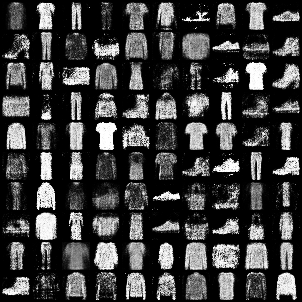

In [71]:
Image('./samples/fake_images-0015.png')

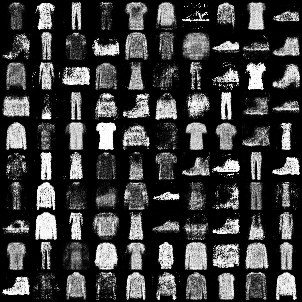

In [72]:
Image('./samples/fake_images-0020.png')

#### Step 8: Load the model weights without using checkpoints.

In [73]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784


# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.load_state_dict(torch.load('G4.pth'))  #loading the saved weights without saving the weights at checkpoint
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.load_state_dict(torch.load('D4.pth'))
D.eval()

/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_84842/3842716364.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('G4.pth'))  #lo

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

Observation:
LSGan are more efficienct than GANs because the reuslts achieved by a GAN in 300 epochs was achieved by LSGan in 100 epochs. LSGans are not as much time consuming as GANs.

In a standard GAN, the discriminator uses a binary cross-entropy loss, which can lead to issues like vanishing gradients, especially when the discriminator becomes too strong. In contrast, LSGANs use a least squares loss for the discriminator, which penalizes samples based on how far they are from the decision boundary, rather than simply categorizing them as real or fake. This change in loss function allows for smoother gradients and can speed up convergence.

Because LSGANs allow for better gradient flow between the generator and discriminator, models trained with LSGAN tend to converge faster and require fewer epochs to achieve similar results compared to standard GANs, as observed. This can also make LSGANs less time-consuming, as they achieve high-quality results in fewer training iterations.